## Computer Vision(CS 436, CS5310, EE513) PA2: Camera Calibration

###  In this part of assignment you'll be determining the intrinsic and extrinsic parameters of a your mobile phone camera using camera calibration techniques. 
### Undergrad students have to strictly follow the handout and implement the procedure outlined in the handout. Grad students can follow the handout and get full marks but they are free to experiment and they can look at other ways of finding the projection matrix but keep in mind that you are not allowed to copy code or pictures, the picture you use for calibration should be your own and should be taken from you own mobile phone camera. You should be able to explain every step of your implementation.
### For this assignment we are using the direct linear transformation method

In [1]:
#Imports
import matplotlib
import cv2
from mpl_toolkits import mplot3d
from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib import image as mpimg
from matplotlib.pyplot import figure
import seaborn as sns
import numpy as np
import matplotlib.pylab as pl
from matplotlib.colors import ListedColormap
from scipy.linalg import null_space
%matplotlib notebook

In [3]:
def click_callback(event,x,y,flags,params):
    if event == cv2.EVENT_LBUTTONDOWN:
        cv2.circle(img,(x,y),10,(255,0,0),-1)
        print(x,y)

img = cv2.imread('cube.jpg')
cv2.namedWindow('cube', cv2.WINDOW_NORMAL)
cv2.setMouseCallback('cube',click_callback)
while(1):
    cv2.imshow('cube',img)
    if cv2.waitKey(33) & 0xff == ord('q'):
        break
cv2.destroyAllWindows()
    

1508 753
1546 1257
1583 1758
1623 2196
1770 777
1804 1334
1833 1884
1852 2364
2148 859
2153 1460
2177 2064
2182 2588
2627 933
2610 1622
2627 2308
2576 2891
3110 871
3084 1495
3062 2114
2997 2653


In [2]:
def read_points(file):
    points = []
    with open(file,'r') as f:
        for i in f.readlines():
            x,y = i.strip("\n").split(" ")
            points.append([int(x),int(y)])
        f.close()
    return points
        
img = cv2.imread('cube.jpg')        
img_points = read_points('2d.txt')

for point in img_points:
    plt.plot(point[0],point[1],'bo',markersize=4)
plt.title("Cube with marked points for Callibration")
plt.imshow(img)

<IPython.core.display.Javascript object>

In [3]:
def read_points3d(file):
    points = []
    with open(file,'r') as f:
        for i in f.readlines():
            x,y,z = i.strip("\n").split(" ")
            points.append([int(x),int(y),int(z)])
        f.close()
    return points

world_points = np.array(read_points3d("3d.txt"))
face_height = 55.88 #mm
scale_factor = int(face_height/3) #mm
world_points *= scale_factor

## Part 1 (30 marks)
### Take image of a calibration object with your camera phone. Unlike shown in the lecture slides here you are required to choose an appropriate 3D calibration object (i.e. a nonplanar object, a rubiks cube for example) so that the world points on that object span a 3-dimensional space, and the image points are easy to mark. Place the calibration object on a horizontal plane, such as a tabletop, or floor, to take the image. Mark at least 20 image points as carefully as possible and establish their world coordinates in millimeters. 
### From this data, compute the camera matrix P. Show the original points and the back-projected camera points on a single image and compute the average re-projection error.

In [4]:
#Refer to Lecture 19: slides 6-12 and slides 19-25

# List of useful funcyions
# u, s, vh = np.linalg.svd(A)
# plt.plot(x, y, 'k+')
# plt.imshow(...)
# plt.show()

#TODO
#A matrix

A =[]
ind = 0
for i in range(0,len(img_points)):
    a = np.array([
        world_points[i][0],world_points[i][1],world_points[i][2],1,0,0,0,0,-img_points[i][0]*world_points[i][0],
        -img_points[i][0]*world_points[i][1],-img_points[i][0]*world_points[i][2],-img_points[i][0]
    ])
    b = np.array([
        0,0,0,0,world_points[i][0],world_points[i][1],world_points[i][2],1,-img_points[i][1]*world_points[i][0],
        -img_points[i][1]*world_points[i][1],-img_points[i][1]*world_points[i][2],-img_points[i][1]
    ])
    A.append(a)
    A.append(b)
A = np.array(A)
u,s,v = np.linalg.svd(A)
P = v[-1].reshape((3,4)) #last column will give the minimum eigen value
print("Projection Matrix",P)

Projection Matrix [[-3.14520684e-03 -2.94683110e-03 -2.01645683e-02 -8.94885409e-01]
 [-1.85619065e-02  1.52225269e-03 -1.55199605e-03 -4.45427094e-01]
 [-1.29652294e-06  3.53143687e-06 -2.94744671e-06 -5.93276350e-04]]


In [5]:
#project 3d points to 2d

homo_world_points = np.concatenate((world_points,np.ones((len(img_points),1))) ,axis = 1)
projections = (homo_world_points@P.T)
projections /= projections[:,2].reshape(-1,1)

#Please refer to the above image as the plotted image will be updated there.
for i in range(projections.shape[0]):
    plt.plot(projections[i][0],projections[i][1],'ro',markersize=4,label='camera points')
    plt.plot(img_points[i][0],img_points[i][1],'bo',markersize=4,label='marked points')
plt.title("Estimated Camera Points")
plt.legend()
plt.imshow(img)

print("AVG Reprojection error {} px".format(np.linalg.norm(projections[:,0:2] - img_points)/projections.shape[0]))

<IPython.core.display.Javascript object>

AVG Reprojection error 4.278443991426232 px


## Part 2 (30 marks)
### Since we are using direct linear transformation, the QR decomposition of a matrix is

In [6]:
from numpy.linalg import qr
from scipy.linalg import rq

def myRQ(matrix):
  Q, L = qr(np.linalg.inv(matrix))
  K, R = np.linalg.inv(L), Q.T
  return K, R


### Compute camera center C, intrinsic matrix K and Rotation matrix R. Generate a 3D figure which shows the calibration points and the camera center (You also have to plot the points for 3d calibration object as well)

Camera Center cords [[ -9.60410017 114.6932745  -59.64225071   1.        ]]


<IPython.core.display.Javascript object>


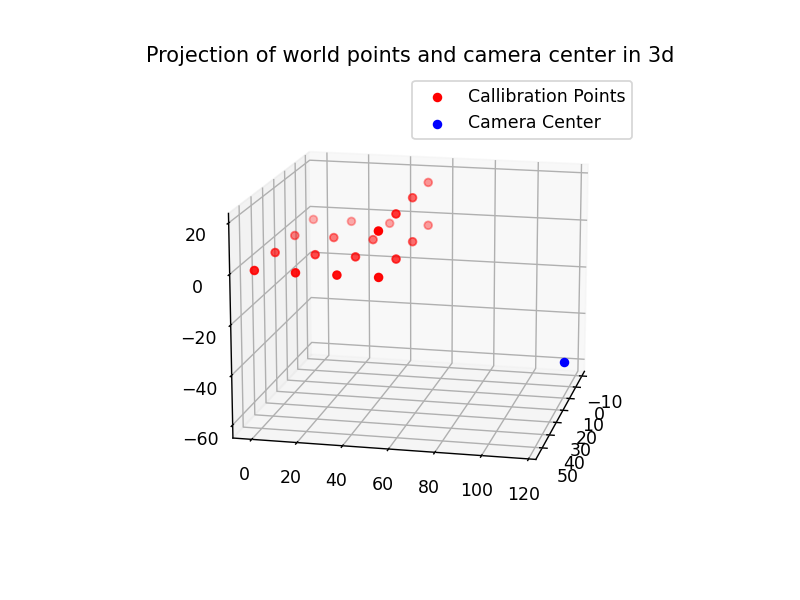

In [7]:
#Refer to Lecture 19: slides 13-17 and slides 26-28

# CAMERA CENTER -- last column of V transpose from svd(P) == nullspace since PC = 0

# List of useful functions:
# K, R = myRQ(KR)
# ax = plt.figure().gca(projection='3d')  
# ax.scatter3D(X, Y, Z, color='c') # points for 3D object
# ax.text(cx, cy, cz, "Camera Center") # text label

#TODO

#camera center

C = null_space(P).reshape((4,1))
C /= C[-1]
print('Camera Center cords',C.reshape(1,4))
fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')
ax.scatter(world_points[:,0],world_points[:,1],world_points[:,2], c='r', marker='o',label='Callibration Points')           
ax.scatter(C[0],C[1],C[2], c='b', marker='o',label='Camera Center') 
plt.title("Projection of world points and camera center in 3d")
plt.legend()
plt.show(ax)

In [8]:
#RQ decomposition
K,R  = myRQ(P[:,:3])
print("Intrinsic K matrix",K)
print()
print("Extrinsic Rotation matrix",R)

Intrinsic K matrix [[-1.73661584e-02  3.52878907e-04 -1.11120643e-02]
 [ 0.00000000e+00  1.72802838e-02 -7.11773206e-03]
 [-0.00000000e+00 -0.00000000e+00 -4.77906479e-06]]

Extrinsic Rotation matrix [[-0.0120365   0.63811743  0.76984497]
 [-0.96242177 -0.21627633  0.16422204]
 [ 0.27129219 -0.7389389   0.61674132]]


## (Grad Only) Part 3 (20 marks)
### Search for the sensor information of your camera on the web. From this information, compute the focal length in mm. The following link may be useful to look up sensor sizes in mm(since most smartphone sensor sizes will be quoted in inches):
https://www.digicamdb.com/sensor-sizes/
### now re-plot everything along with the principal point of camera

In [15]:
#Refer to Lecture 19: slide 29

#TODO